## Figure 3

Comparing signals in the feature space

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(ggrepel))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure3_featureanalysis")
extensions <- c(".png", ".pdf")

### Panel A - Feature heatmaps

In [3]:
consensus_dir <- file.path("..", "1.Data-exploration", "Consensus")

cp_df <- load_consensus_signatures(assay = "cellpainting", data_dir = consensus_dir)
l1000_df <- load_consensus_signatures(assay = "l1000", data_dir = consensus_dir)

In [4]:
# Get correlation of feature spaces
cp_subset_df <- cp_df %>%
    dplyr::filter((Metadata_dose_recode >= 6) | (Metadata_broad_sample == "dmso"))

cp_corr_df <- cp_subset_df %>%
    dplyr::select(starts_with(c("Cells", "Cytoplasm", "Nuclei"))) %>%
    as.matrix() %>%
    Hmisc::rcorr(type = "pearson")

cp_corr_df <- cp_corr_df$r
print(dim(cp_corr_df))

# L1000
l1000_subset_df <- l1000_df %>%
    dplyr::filter((dose >= 6) | (pert_iname == "dmso"))

l1000_corr_df <- l1000_subset_df %>%
    dplyr::select(ends_with("at")) %>%
    as.matrix() %>%
    Hmisc::rcorr(type = "pearson")

l1000_corr_df <- l1000_corr_df$r
print(dim(l1000_corr_df))

[1] 1020 1020
[1] 974 974


In [5]:
cp_heat_gg <- grid::grid.grabExpr(
    draw(
        Heatmap(
            cp_corr_df,
            col = feature_legend_scale_cols,
            
            show_row_names = FALSE,
            show_column_names = FALSE,

            column_title = paste0("Cell Painting features\n(n=", dim(cp_corr_df)[1], ")"),

            heatmap_legend_param = list(
                    title = "Pearson\ncorrelation",
                    color_bar = "continuous",
                    col_fun = legend_scale_cols,
                    title_gp = gpar(fontsize = lgd_title_fontsize),
                    title_position = "topleft",
                    labels_gp = gpar(fontsize = lgd_label_fontsize),
                    legend_height = unit(3, "cm")
            )
        )
    )
)

In [6]:
l1000_heat_gg <- grid::grid.grabExpr(
    draw(
        Heatmap(
            l1000_corr_df,
            col = feature_legend_scale_cols,

            show_row_names = FALSE,
            show_column_names = FALSE,

            column_title = paste0("L1000 features\n(n=", dim(l1000_corr_df)[1], ")"),

            heatmap_legend_param = list(
                    title = "Pearson\ncorrelation",
                    color_bar = "continuous",
                    col_fun = legend_scale_cols,
                    title_gp = gpar(fontsize = lgd_title_fontsize),
                    title_position = "topleft",
                    labels_gp = gpar(fontsize = lgd_label_fontsize),
                    legend_height = unit(3, "cm")
            )
        )
    )
)

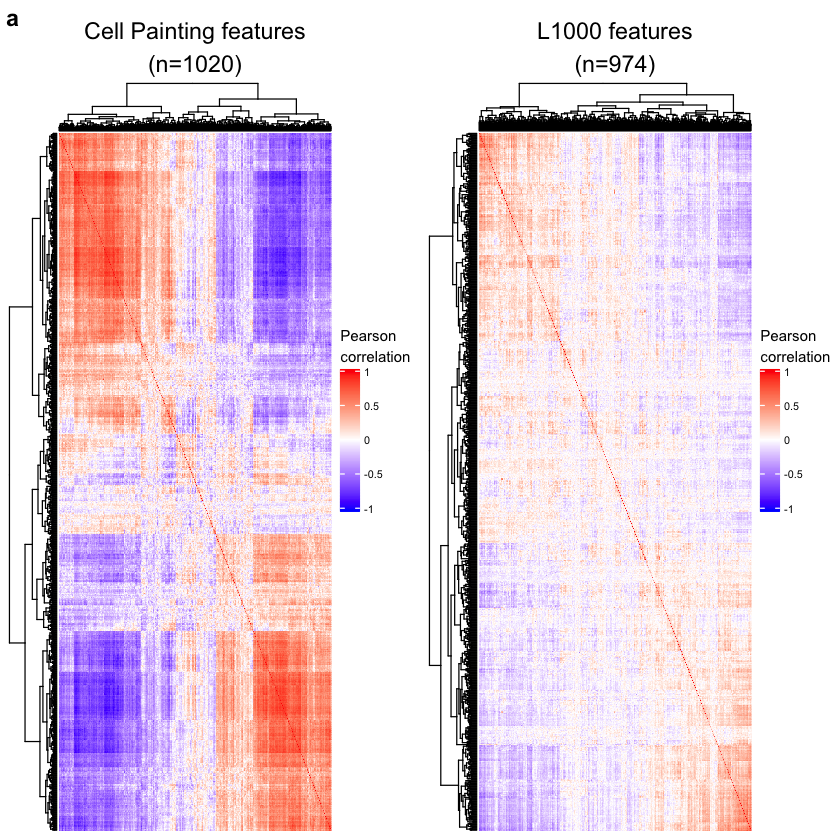

In [7]:
panel_a_gg <- cowplot::plot_grid(
    cp_heat_gg,
    l1000_heat_gg,
    ncol = 2,
    labels = c("a", ""),
    rel_widths = c(1, 1)
)

panel_a_gg

## Panel B

In [8]:
l1000_all_cors <- l1000_corr_df[lower.tri(l1000_corr_df, diag=FALSE)] %>%
    dplyr::as_tibble() %>%
    dplyr::mutate(assay="L1000")

cp_all_cors <- cp_corr_df[lower.tri(cp_corr_df, diag=FALSE)] %>%
    dplyr::as_tibble() %>%
    dplyr::mutate(assay="Cell Painting")

all_cors <- dplyr::bind_rows(l1000_all_cors, cp_all_cors)

head(all_cors, 2)

value,assay
<dbl>,<chr>
-0.07116451,L1000
-0.10754578,L1000


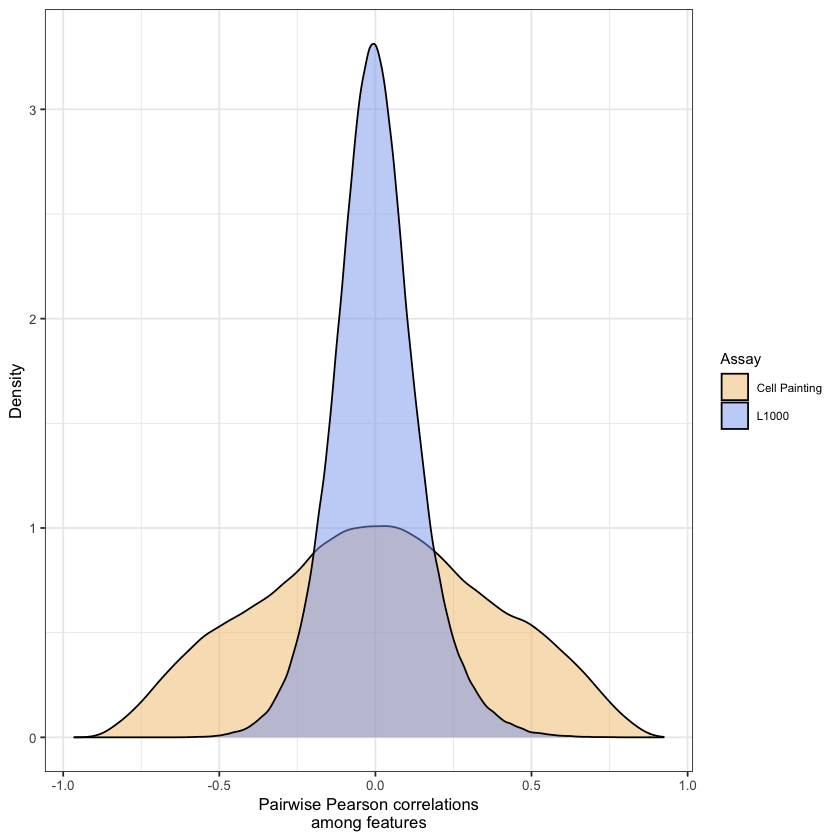

In [9]:
panel_b_gg <- (
    ggplot(all_cors, aes(x = value))
    + geom_density(aes(fill = assay), alpha = 0.5)
    + figure_theme
    + scale_fill_manual("Assay", values = assay_colors)
    + xlab("Pairwise Pearson correlations\namong features")
    + ylab("Density")
    + theme(legend.position = "right")
)

panel_b_gg

### Panel C

In [10]:
# Load PCA explained variance
pca_dir <- file.path("..", "3.clustering-pca", "results")

cp_file <- file.path(pca_dir, "cell_painting", "cp_pca_explained_variance.csv")
l1000_file <- file.path(pca_dir, "L1000", "L1000_pca_explained_variance.csv")

In [11]:
pc_cols <- readr::cols(
    var = readr::col_double(),
    PC = readr::col_character()
)

cp_pca_df <- readr::read_csv(cp_file, col_types = pc_cols) %>%
    dplyr::mutate(assay = "Cell Painting", prop_var = cumsum(var))
l1000_pca_df <- readr::read_csv(l1000_file, col_types = pc_cols) %>%
    dplyr::mutate(assay = "L1000", prop_var = cumsum(var))

pca_df <- dplyr::bind_rows(cp_pca_df, l1000_pca_df) %>%
    dplyr::mutate(PC_num = as.numeric(paste(gsub("PC", "", PC))))

head(pca_df)

var,PC,assay,prop_var,PC_num
<dbl>,<chr>,<chr>,<dbl>,<dbl>
23.463378,PC1,Cell Painting,23.46338,1
4.311208,PC2,Cell Painting,27.77459,2
3.996297,PC3,Cell Painting,31.77088,3
2.874340,PC4,Cell Painting,34.64522,4
2.804951,PC5,Cell Painting,37.45017,5
2.388214,PC6,Cell Painting,39.83839,6


In [12]:
pca_var_gg <- (
    ggplot(pca_df, aes(x = PC_num, y = prop_var, color = assay))
    + geom_line()
    + figure_theme
    + scale_color_manual("Assay", values = assay_colors)
    + ylab("Cumulative\nvariance\nexplained (%)")
    + xlab("Principal\ncomponent\nnumber")
    + theme(legend.position = "none")
)

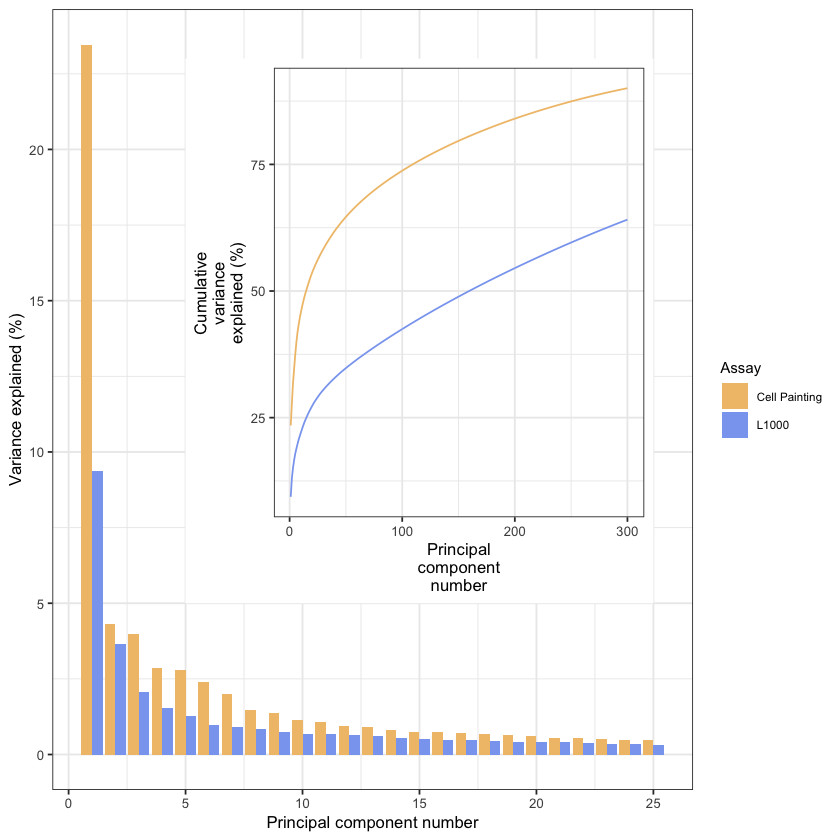

In [13]:
panel_c_gg <- (
    ggplot(pca_df %>% dplyr::filter(PC_num <= 25), aes(x = PC_num, y = var, fill = assay))
    + geom_bar(stat = "identity", position = "dodge")
    + figure_theme
    + scale_fill_manual("Assay", values = assay_colors)
    + ylab("Variance explained (%)")
    + xlab("Principal component number")
    + theme(legend.position = "right")
)

panel_c_gg <- cowplot::ggdraw(panel_c_gg + cowplot::draw_plot(pca_var_gg, 5, 5, 20, 18))
panel_c_gg

### Panel D

In [14]:
# Load Signature Strength and MAS scores
results_dir <- file.path("..", "1.Data-exploration", "Profiles_level4")

cell_painting_file <- file.path(results_dir, "cell_painting", "cellpainting_lvl4_cpd_replicate_datasets", "cp_all_scores.csv")
l1000_file <- file.path(results_dir, "L1000", "L1000_lvl4_cpd_replicate_datasets", "L1000_all_scores.csv")

ss_cols <- readr::cols(
    .default = readr::col_double(),
    cpd = readr::col_character(),
    dose = readr::col_character()
)

cp_ss_df <- readr::read_csv(cell_painting_file, col_types = ss_cols)
l1000_ss_df <- readr::read_csv(l1000_file, col_types = ss_cols)

# Load MOA info
moa_file <- file.path(results_dir, "aligned_moa_CP_L1000.csv")

moa_cols <- readr::cols(
    Metadata_broad_sample = readr::col_character(),
    broad_id = readr::col_character(),
    pert_iname = readr::col_character(),
    moa = readr::col_character()
)

moa_df <- readr::read_csv(moa_file, col_types = moa_cols)

# Load data on whether compound passed threshold
sig_file <- file.path("data", "significant_compounds_by_threshold_both_assays.tsv.gz")

sig_cols <- readr::cols(
    compound = readr::col_character(),
    dose = readr::col_character(),
    median_replicate_score_cellpainting = readr::col_double(),
    median_replicate_score_l1000 = readr::col_double(),
    pass_cellpainting_thresh = readr::col_logical(),
    pass_l1000_thresh = readr::col_logical(),
    pass_both = readr::col_logical(),
    cell_painting_num_reproducible = readr::col_double(),
    l1000_num_reproducible = readr::col_double(),
    total_reproducible = readr::col_double()
)

significant_compounds_df <- readr::read_tsv(sig_file, col_types = sig_cols)

head(significant_compounds_df)

compound,dose,median_replicate_score_cellpainting,median_replicate_score_l1000,pass_cellpainting_thresh,pass_l1000_thresh,pass_both,cell_painting_num_reproducible,l1000_num_reproducible,total_reproducible
<chr>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
17-hydroxyprogesterone-caproate,0.04 uM,0.05455739,0.073369676,TRUE,FALSE,FALSE,5,2,7
2-iminobiotin,0.04 uM,0.05379096,0.085433608,TRUE,FALSE,FALSE,1,2,3
3-amino-benzamide,0.04 uM,0.11193277,0.011228047,TRUE,FALSE,FALSE,5,0,5
3-deazaadenosine,0.04 uM,0.01575401,0.068821714,FALSE,FALSE,FALSE,3,1,4
abt-737,0.04 uM,0.01617358,0.025780406,FALSE,FALSE,FALSE,5,1,6
aica-ribonucleotide,0.04 uM,0.03444687,0.003927588,FALSE,FALSE,FALSE,1,0,1


In [15]:
ss_df <- cp_ss_df %>%
    dplyr::inner_join(l1000_ss_df, by = c("cpd", "dose"), suffix = c("_cellpainting", "_l1000")) %>%
    dplyr::left_join(moa_df, by = c("cpd" = "pert_iname")) %>%
    dplyr::left_join(significant_compounds_df, by = c("cpd" = "compound", "dose" = "dose"))

output_file <- file.path("data", "compound_activity_full.tsv")
ss_df %>% readr::write_tsv(output_file)

ss_df$dose <- factor(ss_df$dose, levels = dose_order)

print(dim(ss_df))
head(ss_df, 2)

[1] 7992   19


cpd,dose,replicate_correlation_cellpainting,signature_strength_cellpainting,MAS,replicate_correlation_l1000,signature_strength_l1000,TAS,Metadata_broad_sample,broad_id,moa,median_replicate_score_cellpainting,median_replicate_score_l1000,pass_cellpainting_thresh,pass_l1000_thresh,pass_both,cell_painting_num_reproducible,l1000_num_reproducible,total_reproducible
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
17-hydroxyprogesterone-caproate,0.04 uM,0.06065485,338.6,0.1601253,0.02473778,263.0000,0.08156217,BRD-A29731977-001-04-5,BRD-A29731977,Progesterone receptor agonist,0.05455739,0.07336968,TRUE,FALSE,FALSE,5,2,7
2-iminobiotin,0.04 uM,0.04270010,334.2,0.1334755,-0.13369283,242.3333,0.00000000,BRD-K07954936-001-01-3,BRD-K07954936,Nitric oxide synthase inhibitor,0.05379096,0.08543361,TRUE,FALSE,FALSE,1,2,3


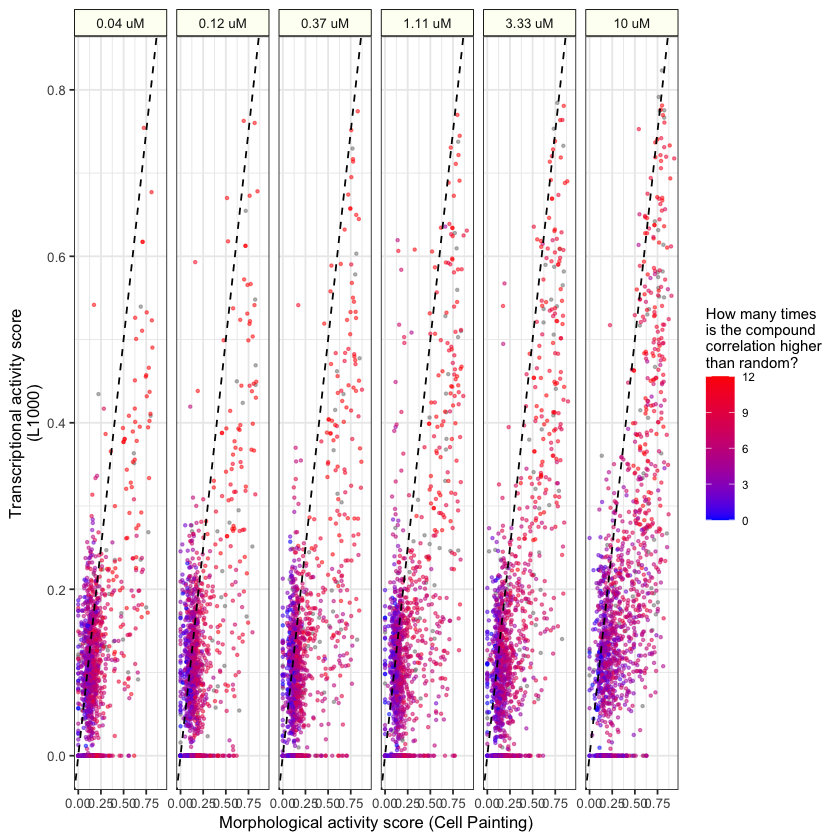

In [16]:
panel_d_gg <- (
    ggplot(ss_df, aes(x = MAS, y = TAS))
    + geom_point(aes(color = total_reproducible), size = 0.6, alpha = 0.5)
    + facet_grid("~dose")
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + figure_theme
    + scale_color_gradient("How many times\nis the compound\ncorrelation higher\nthan random?", low = "blue", high = "red")
    + xlab("Morphological activity score (Cell Painting)")
    + ylab("Transcriptional activity score\n(L1000)")
)

panel_d_gg

## Panel E

In [17]:
top_diff_activity_df <- ss_df %>%
    dplyr::filter(
        cell_painting_num_reproducible > 3,
        l1000_num_reproducible > 3
    ) %>%
    dplyr::group_by(cpd) %>%
    dplyr::summarize(mas_mean = mean(MAS), tas_mean = mean(TAS), cpd_count = sum(total_reproducible)) %>%
    dplyr::mutate(mas_tas_dff = mas_mean - tas_mean) %>%
    dplyr::arrange(desc(mas_tas_dff))

output_file <- file.path("data", "highmas_lowtas_compounds.tsv")
top_diff_activity_df %>% readr::write_tsv(output_file)

head(top_diff_activity_df)

cpd,mas_mean,tas_mean,cpd_count,mas_tas_dff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
alisertib,0.7093481,0.2001189,60,0.5092291
dasatinib,0.7255265,0.2476898,60,0.4778368
brequinar,0.6381176,0.1985246,60,0.4395931
aphidicolin,0.7069061,0.2673556,60,0.4395504
at13387,0.7433610,0.3197050,66,0.4236560
sta-5326,0.7084493,0.2868042,72,0.4216451


In [18]:
tail(top_diff_activity_df) %>% dplyr::arrange(mas_tas_dff)

cpd,mas_mean,tas_mean,cpd_count,mas_tas_dff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
l-ergothioneine,0.1768014,0.4669131,66,-0.29011168
lasalocid,0.3551927,0.4998409,72,-0.14464822
enzastaurin,0.2501894,0.3087260,54,-0.05853658
alvocidib,0.6275581,0.6615432,72,-0.03398507
tak-733,0.5194017,0.5426074,72,-0.02320574
resminostat,0.3524174,0.3536333,60,-0.00121591


In [19]:
color_logic <- (
    top_diff_activity_df$mas_tas_dff > 0.40 |
    top_diff_activity_df$mas_tas_dff < 0 | 
    top_diff_activity_df$tas_mean > 0.71
    )

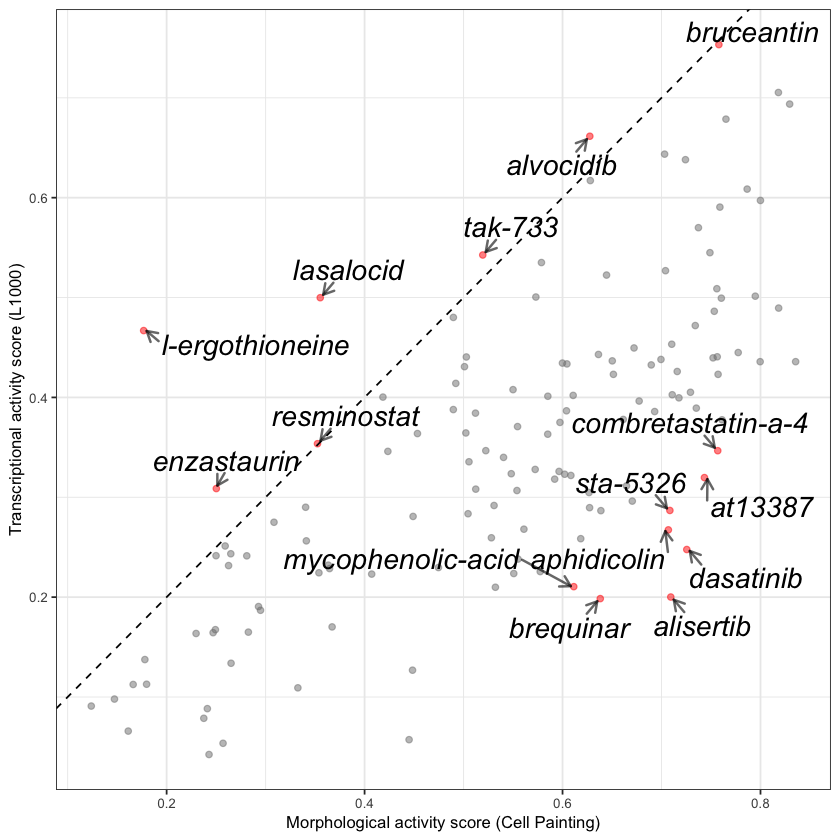

In [20]:
panel_e_gg <- (
    ggplot(top_diff_activity_df, aes(x = mas_mean, y = tas_mean))
    + geom_point(color = ifelse(color_logic, "red", "grey50"), alpha = 0.5)
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + figure_theme
    + xlab("Morphological activity score (Cell Painting)")
    + ylab("Transcriptional activity score (L1000)")
    + geom_text_repel(
        data = subset(top_diff_activity_df, color_logic),
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.7,
        segment.alpha = 0.6,
        size = 6,
        fontface = "italic",
        box.padding = 0.5,
        point.padding = 0.25,
        aes(
            x = mas_mean,
            y = tas_mean,
            label = cpd,
        )
    )
)

panel_e_gg

## Panel F

In [21]:
# Load overrepresentation analysis results
ora_results_dir <- file.path("..", "5.Gene-analysis", "results")

ora_results_file <- file.path(ora_results_dir, "ora_compound_results.tsv")

ora_cols <- readr::cols(
    geneSet = readr::col_character(),
    description = readr::col_character(),
    link = readr::col_character(),
    size = readr::col_double(),
    overlap = readr::col_double(),
    expect = readr::col_double(),
    enrichmentRatio = readr::col_double(),
    pValue = readr::col_double(),
    FDR = readr::col_double(),
    overlapId = readr::col_character(),
    database = readr::col_character(),
    userId = readr::col_character(),
    compound = readr::col_character()
)

ora_df <- readr::read_tsv(ora_results_file, col_types = ora_cols)

print(dim(ora_df))
head(ora_df, 3)

[1] 80 13


geneSet,description,link,size,overlap,expect,enrichmentRatio,pValue,FDR,overlapId,database,userId,compound
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
GO:0003824,catalytic activity,http://amigo.geneontology.org/amigo/term/GO:0003824,448,22,13.9249732,1.579895,0.001851467,1,329;998;1017;1026;1643;1738;1983;2778;3162;5255;5603;8318;9133;10038;10730;23139;23536;27244;55008;55256;55699;60493,geneontology_Molecular_Function,PHKA1;MAST2;SESN1;CDK2;IARS2;CDKN1A;MAPK13;DLD;CDC42;HMOX1;ADAT1;BIRC2;HERC6;CDC45;ADI1;YME1L1;FASTKD5;GNAS;CCNB2;EIF5;DDB2;PARP2,alisertib
GO:0004674,protein serine/threonine kinase activity,http://amigo.geneontology.org/amigo/term/GO:0004674,68,7,2.1136120,3.311866,0.003438725,1,998;1017;1026;5255;5603;9133;23139,geneontology_Molecular_Function,PHKA1;MAST2;CDK2;CDKN1A;MAPK13;CDC42;CCNB2,alisertib
GO:1902554,serine/threonine protein kinase complex,http://amigo.geneontology.org/amigo/term/GO:1902554,23,4,0.7148982,5.595202,0.004434779,1,1017;1026;5255;9133,geneontology_Cellular_Component,PHKA1;CDK2;CDKN1A;CCNB2,alisertib


In [22]:
cpd_targets <- c(
    "alisertib" = "Alisertib",
    "dasatinib" = "Dasatinib",
    "brequinar" = "Brequinar",
    "aphidicolin" = "Aphidicolin",
    "at13387" = "at13387",
    "sta-5326" = "sta-5326",
    "l-ergothioneine" = "l-Ergothioneine",
    "lasalocid" = "Lasalocid"
)

cpd_colors <- c(
    "alisertib" = "#1b9e77",
    "dasatinib" = "#d95f02",
    "brequinar" = "#7570b3",
    "aphidicolin" = "#e7298a",
    "at13387" = "#a6761d",
    "sta-5326" = "#666666",
    "l-ergothioneine" = "#66a61e",
    "lasalocid" = "#e6ab02" 
)

In [23]:
# Added to plot
ora_subset_df <- ora_df %>%
    dplyr::group_by(compound) %>%
    dplyr::arrange(desc(enrichmentRatio)) %>%
    dplyr::filter(row_number() == 1) %>%
    dplyr::select(geneSet, description, enrichmentRatio, pValue, compound)

ora_subset_df$compound <- paste(ora_subset_df$compound)

ora_subset_df

geneSet,description,enrichmentRatio,pValue,compound
<chr>,<chr>,<dbl>,<dbl>,<chr>
GO:0006695,cholesterol biosynthetic process,13.822222,6.679682e-09,sta-5326
GO:0009267,cellular response to starvation,12.276316,1.405702e-03,aphidicolin
GO:0044272,sulfur compound biosynthetic process,9.260546,5.803719e-04,dasatinib
GO:1902554,serine/threonine protein kinase complex,5.595202,4.434779e-03,alisertib
GO:0034644,cellular response to UV,4.910526,1.731779e-04,brequinar
GO:0044264,cellular polysaccharide metabolic process,3.642499,7.790210e-04,lasalocid
GO:0010594,regulation of endothelial cell migration,3.308511,7.411365e-04,at13387
GO:0043487,regulation of RNA stability,2.681034,6.087614e-03,l-ergothioneine


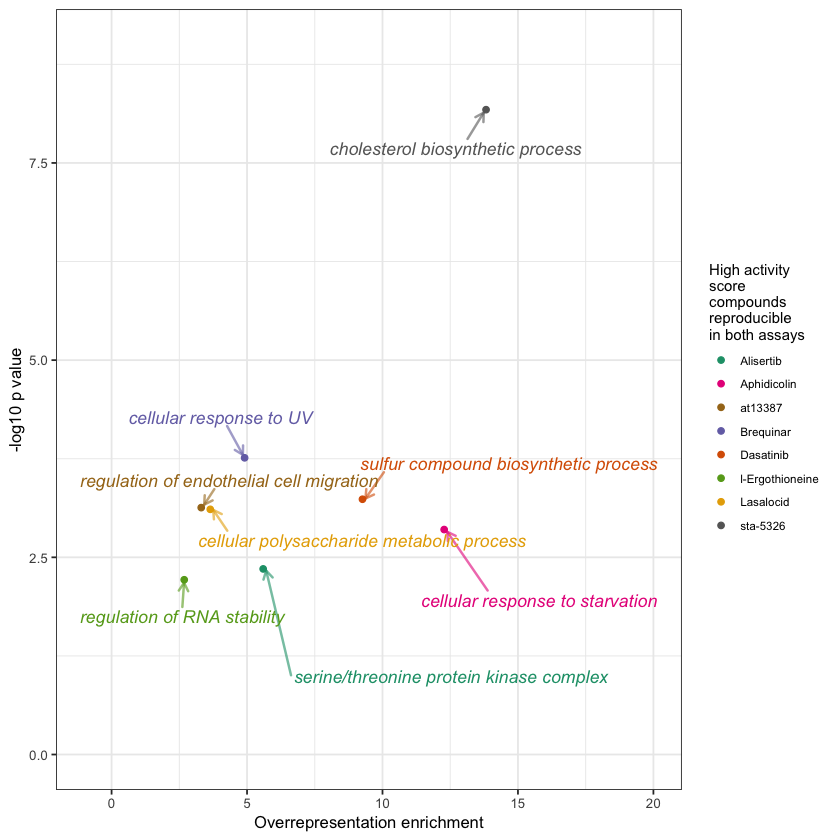

In [24]:
panel_f_gg <- (
    ggplot(ora_subset_df, aes(x = enrichmentRatio, y = -log10(pValue), color = compound))
    + geom_point()
    + ggrepel::geom_text_repel(
        data = ora_subset_df,
        aes(label = description),
        force = 9,
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.7,
        segment.alpha = 0.6,
        size = 3.75,
        fontface = "italic",
        box.padding = 1,
        point.padding = 0.25,
        show.legend = FALSE
    )
    + figure_theme
    + ylim(c(0, 9))
    + xlim(c(-1, 20))
    + scale_color_manual("High activity\nscore\ncompounds\nreproducible\nin both assays", labels = cpd_targets, values = cpd_colors)
    + xlab("Overrepresentation enrichment")
    + ylab("-log10 p value")
    + theme(legend.position = "right", legend.key.size = unit(0.5, "cm"))
    + guides(color = guide_legend(ncol = 1))
)

panel_f_gg

In [25]:
# Merge panels together
top_right_gg <- cowplot::plot_grid(
    cowplot::ggdraw(),
    panel_b_gg + theme(plot.margin = margin(t = 10)),
    cowplot::ggdraw(),
    panel_c_gg + theme(plot.margin = margin(b = -15)),
    nrow = 4,
    labels = c("b", "", "", "c"),
    rel_heights = c(0.2, 0.75, 0.1, 1.5),
    align = "h"
)

top_gg <- cowplot::plot_grid(
    cowplot::plot_grid(
        panel_a_gg,
        cowplot::ggdraw(),
        nrow = 2,
        rel_heights = c(1, 0.1)
    ),
    top_right_gg,
    ncol = 2,
    rel_widths = c(1, 0.5),
    align = "h"
)

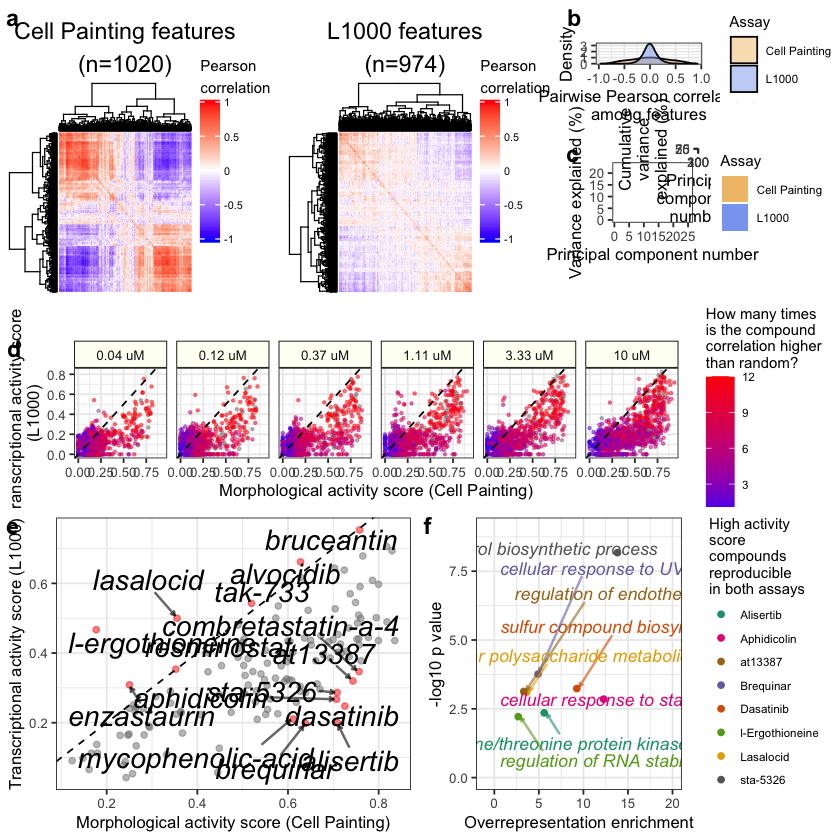

In [26]:
bottom_gg <- cowplot::plot_grid(
    panel_e_gg,
    panel_f_gg,
    ncol = 2,
    align = "h",
    labels = c("e", "f")
)

figure_4_gg <- cowplot::plot_grid(
    top_gg,
    panel_d_gg,
    bottom_gg,
    nrow = 3,
    rel_heights = c(0.75, 0.4, 0.75),
    labels = c("", "d", "")
)

figure_4_gg

In [27]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, figure_4_gg, base_width = 13, base_height = 13, dpi = 500)
}